<a href="https://colab.research.google.com/github/emely3h/Geospatial_ML/blob/feature%2Fcreate-mask/Copy_of_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training an Unet

This notebook aims to train an Unet to make predictions based on the first 10 images in the dataset, located in data/data_rgb:
- 2022_06_20
- 2022_07_05 ???
- 2022_07_15
- 2022_07_10
- 2022_07_25
- 2022_07_30
- 2022_08_04
- 2022_08_09
- 2022_08_14
- 2022_08_24
- 2022_09_03
- 2022_09_08
- 2022_09_13
- 2022_09_18
- 2022_10_13
- 2022_10_23
- 2022_12_02
- 2022_12_12



In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
! ls
%cd drive/MyDrive/MachineLearning
! ls

architecture.drawio  notebooks	   README.md
models		     prepare_data  requirements.txt
architecture.drawio  notebooks	   README.md
models		     prepare_data  requirements.txt


In [ ]:
#! git clone https://github.com/emely3h/Geospatial_ML
%cd Geospatial_ML
! git checkout feature/create_mask
#! ls


/content/drive/MyDrive/MachineLearning/Geospatial_ML
error: pathspec 'feature/create_mask' did not match any file(s) known to git


In [18]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from models.simple_multi_unet_model import multi_unet_model

14 images in total, as tiles overlap, we don't want to have tiles from the same original image in the training/ test or validation dataset. Therefore we split the dataset accordingly:

- training data: 13
- validation data: 3 images
- test data: 2 images

In [60]:
data_directory = "../data_colab/256_200_1_missing"

# np.load(os.path.join(root_directory, 'y_input.npy'))
# normalize + do one hot encoding while loading

y_train  = np.load(os.path.join(data_directory, 'y_mask_256_200_2022_06_20.npy'))
X_train  = np.load(os.path.join(data_directory, 'x_input_256_200_2022_06_20.npy'))

y_val = np.load(os.path.join(data_directory, 'y_mask_256_200_2022_07_10.npy'))
X_val = np.load(os.path.join(data_directory, 'x_input_256_200_2022_07_10.npy'))

y_test = np.load(os.path.join(data_directory, 'y_mask_256_200_2022_07_15.npy'))
X_test = np.load(os.path.join(data_directory, 'x_input_256_200_2022_07_15.npy'))


print(y_train.shape)
print(X_train.shape)

print(y_val.shape)
print(X_val.shape)

print(y_test.shape)
print(X_test.shape)

(1251, 256, 256)
(1251, 256, 256, 5)
(1323, 256, 256)
(1323, 256, 256, 5)
(864, 256, 256)
(864, 256, 256, 5)


In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if len(display_list[i].shape) == 3:
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    else:
        plt.imshow(display_list[i])
  plt.show()

In [13]:
sample_image, sample_mask = X_train[5], y_train[5]
sample_image = sample_image[..., :4]
print(sample_image.shape)
print(sample_mask.shape)
display([sample_image, sample_mask])

(256, 256, 4)
(256, 256)


[array([[[113., 132., 110., 255.],
         [113., 131., 111., 255.],
         [112., 131., 110., 255.],
         ...,
         [110., 130., 109., 255.],
         [110., 130., 110., 255.],
         [109., 129., 110., 255.]],
 
        [[114., 132., 110., 255.],
         [113., 131., 110., 255.],
         [111., 130., 110., 255.],
         ...,
         [106., 127., 107., 255.],
         [106., 126., 106., 255.],
         [106., 125., 105., 255.]],
 
        [[113., 131., 111., 255.],
         [113., 131., 110., 255.],
         [111., 131., 110., 255.],
         ...,
         [103., 125., 103., 255.],
         [102., 121., 100., 255.],
         [ 99., 118., 100., 255.]],
 
        ...,
 
        [[109., 130., 110., 255.],
         [109., 130., 109., 255.],
         [109., 130., 110., 255.],
         ...,
         [104., 128., 109., 255.],
         [105., 128., 107., 255.],
         [105., 127., 108., 255.]],
 
        [[109., 130., 108., 255.],
         [109., 130., 110., 255.],
       

### 2. Normalizing

In [14]:
def normalizing(X, y):

  print(y.shape)
  y_one_hot =  np.array([tf.one_hot(item, depth=4).numpy() for item in y])
  print(y_one_hot.shape)
  X_normal = X/255
  return X_normal, y_one_hot

In [ ]:
#print(np.max(y_one_hot))
#print(np.min(y_one_hot))

1.0
0.0


In [61]:
X_train, y_train = normalizing(X_train, y_train)

X_val, y_val = normalizing(X_val, y_val)

X_test, y_test = normalizing(X_test, y_test)


(1251, 256, 256)
(1251, 256, 256, 4)
(1323, 256, 256)
(1323, 256, 256, 4)
(864, 256, 256)
(864, 256, 256, 4)


### 3. Building the unet model

In [28]:
from keras.models import Model
from keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    concatenate,
    Conv2DTranspose,
    Dropout,
    UpSampling2D
)

def unet_2d(input_shape, num_classes):

    # Define the input layer
    inputs = Input(input_shape)

    # Downsample layers
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Upsample layers
    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    # Output layer
    output = Conv2D(num_classes, (1, 1), activation='softmax')(conv7)

    # Define the model
    model = Model(inputs=[inputs], outputs=[output])

    return model

In [35]:

from keras.losses import categorical_crossentropy
#model = multi_unet_model(4, 256, 256)
model = unet_2d(input_shape=(256, 256, 5), num_classes=4)
#model.summary()

### 4. Training the model

In [30]:


# Hyperparameters
training_parameters = {
    "loss": "binary_crossentropy",
    "optimizer": "adam",
    "monitored_func": "val_loss",
    "epochs": 100,
}



In [34]:
print(X_train.shape)
print(y_train.shape)

(1251, 256, 256, 5)
(1251, 256, 256, 4)


In [38]:
model.compile(optimizer='adam',
              loss=categorical_crossentropy, # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor=training_parameters["monitored_func"], patience=5, restore_best_weights=True)
model_history = model.fit(x=X_train, y=y_train, epochs=5,
                          #steps_per_epoch=STEPS_PER_EPOCH,
                          #validation_steps=VALIDATION_STEPS,
                          #validation_data=test_batches,
                          #callbacks=[early_stopping]
                          )



Epoch 1/5
40/40 [==============================] - 12s 181ms/step - loss: 0.1695 - accuracy: 0.9604
Epoch 2/5
40/40 [==============================] - 7s 180ms/step - loss: 0.0629 - accuracy: 0.9784
Epoch 3/5
40/40 [==============================] - 7s 180ms/step - loss: 0.0567 - accuracy: 0.9794
Epoch 4/5
40/40 [==============================] - 7s 180ms/step - loss: 0.0521 - accuracy: 0.9808
Epoch 5/5
40/40 [==============================] - 7s 180ms/step - loss: 0.0476 - accuracy: 0.9817


In [58]:
loss = model_history.history['loss']
print(model_history.history)


{'loss': [0.16947443783283234, 0.0629473477602005, 0.056705135852098465, 0.052061744034290314, 0.04762805253267288], 'accuracy': [0.9603721499443054, 0.9784483909606934, 0.9793990850448608, 0.9808446168899536, 0.9817379713058472]}


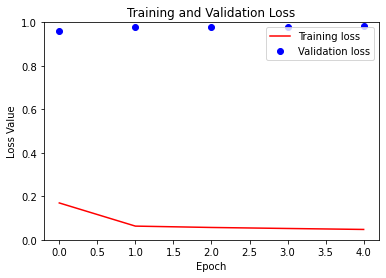

In [59]:
val_loss = model_history.history['accuracy']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

### 5. Saving the model

In [62]:
model_name = '256_200.h5'
#model.save(f'../models/{model_name}')

model = keras.models.load_model(f'../models/{model_name}')

In [63]:
predictions = model.predict(X_test)

27/27 [==============================] - 2s 63ms/step


In [64]:
def jacard_coef(y_true, y_pred):
  y_true_f = keras.backend.flatten(y_true)
  y_pred_f = keras.backend.flatten(y_pred)
  intersection = keras.backend.sum(y_true_f * y_pred_f)
  return (intersection + 1.0) / (
      keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) - intersection + 1.0
  )

In [66]:
jacard_result = jacard_coef(y_test, predictions)
print(jacard_result)

tf.Tensor(0.8130482, shape=(), dtype=float32)


### 6. Analyzing the results
- predifined success metrics
- printing loss and validation functions
- making predictions

### 7. Summary